In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DDPM iki temel aşamadan oluşur:

**İleri Süreç (Forward Process):** Gerçek veriye gürültü ekleyerek tamamen rastgele bir hale getiririz.

**Geri Süreç (Reverse Process):** Rastgele gürültüden başlayarak, bu gürültüyü adım adım temizleyip orijinal veriyi geri oluştururuz.

Bu iki süreçte, UNet kullanılır. UNet, her adımda gürültüyü ne kadar temizleyeceğimizi tahmin eder.

### **İleri Süreç (Forward Process)**

İleri süreçte, orijinal veriye ($x_0$) adım adım gürültü eklenir ve $t$ adımında $x_t$ elde edilir. Bu süreç bir Markov zinciridir ve her adımda Gaussian gürültü eklenir.

Formül:

$$ q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I) $$

Burada:
- $q(x_t | x_{t-1})$: $t-1$ adımından $t$ adımına geçiş olasılığı.
- $\mathcal{N}$: Gaussian (normal) dağılım.
- $\beta_t$: $t$ adımında eklenen gürültü miktarı.
- $I$: Birim matris.

### **İleri Süreç Kısayolu**

Her adımı tek tek hesaplamak yerine, $x_0$'dan direkt $x_t$'ye şu formülle geçebiliriz:

$$ x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon $$

Burada:
- $\bar{\alpha}_t = \prod_{s=1}^t (1 - \beta_s)$: Tüm adımlardaki gürültü birikimini temsil eder.
- $\epsilon \sim \mathcal{N}(0, I)$: Rastgele Gaussian gürültü.


### **Geri Süreç (Reverse Process)**

Geri süreçte, rastgele gürültüden ($x_T$) başlayarak orijinal veriye ($x_0$) ulaşılır. Bu süreç, sinir ağı tarafından tahmin edilir.

Formül:

$$ p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t)) $$

Burada:
- $p_\theta$: Sinir ağı parametreleri $\theta$ ile tanımlı olasılık.
- $\mu_\theta(x_t, t)$: Sinir ağının tahmin ettiği ortalama.
- $\Sigma_\theta(x_t, t)$: Varyans (genelde $\beta_t I$ olarak alınır) veya bir ölçeklendirilmiş versiyonu:

$$ \Sigma_\theta(x_t, t) = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t I $$


### **Geri Süreç Ortalaması**

Geri süreçte sinir ağı, gürültüyü ($\epsilon$) tahmin eder ve ortalama şu şekilde hesaplanır:

$$ \mu_\theta(x_t, t) = \frac{1}{\sqrt{1-\beta_t}} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) $$

Burada:
- $\epsilon_\theta(x_t, t)$: Sinir ağının $t$ adımında tahmin ettiği gürültü.

### **Kayıp Fonksiyonu**

DDPM’yi eğitmek için kullanılan kayıp fonksiyonu, gerçek gürültü ile tahmin edilen gürültü arasındaki farkı minimize eder.

Formül:

$$ L = \mathbb{E}_{x_0, \epsilon, t} \left[ || \epsilon - \epsilon_\theta(x_t, t) ||^2 \right] $$

Burada:
- $\mathbb{E}$: Beklenen değer (ortalama).
- $|| \cdot ||^2$: Mean Squared Error (MSE).

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.utils import make_grid
import glob
import os
import random
import shutil
from PIL import Image
import zipfile
from tqdm import tqdm
import numpy as np
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

## **Configuration Params**

In [ ]:
config = {
    'dataset_params': {
        'im_path': '/content/drive/MyDrive/DDPM/afhq'
    },
    'diffusion_params': {
        'num_timesteps': 800,
        'beta_start': 0.0001,
        'beta_end': 0.02
    },
    'model_params': {
        'im_channels': 3,
        'im_size': 64,
        'encode_channels': [32, 64, 128, 256],
        'mid_channels': [256, 256, 128],
        'down_sample': [True, True, True, False],
        'time_emb_dim': 128,
        'num_encode_layers': 2,
        'num_mid_layers': 2,
        'num_decode_layers': 2,
        'num_heads': 4
    },
    'train_params': {
        'task_name': '/content/drive/MyDrive/DDPM/first_ddpm_training',
        'batch_size': 8,
        'num_epochs': 64,
        'num_samples': 20,
        'num_grid_rows': 5,
        'lr': 0.0001,
        'ckpt_name': '/content/drive/MyDrive/DDPM/ddpm_ckpt.pth'
    }
}

## **Noise Scheduler**

In [ ]:
class NoiseScheduler:
  def __init__(self, timesteps, beta_start, beta_end):
    self.num_timestemps = timesteps
    self.beta_start = beta_start
    self.beta_end = beta_end

    self.betas = torch.linspace(self.beta_start, self.beta_end, self.num_timestemps)
    self.alphas = 1. - self.betas
    self.alpha_cumulative_product = torch.cumprod(self.alphas, dim=0)
    self.sqrt_alpha_cumulative_product = torch.sqrt(self.alpha_cumulative_product)
    self.sqrt_one_min_alpha_cumulative_product = torch.sqrt(1-self.alpha_cumulative_product)

  def add_noise(self, img, noise, t):
    img_shape = img.shape
    batch_size = img_shape[0]

    sqrt_alpha_cumulative_product = self.sqrt_alpha_cumulative_product.to(img.device)[t].reshape(batch_size)
    sqrt_one_min_alpha_cumulative_product= self.sqrt_one_min_alpha_cumulative_product.to(img.device)[t].reshape(batch_size)
    for _ in range(len(img_shape) - 1):
      sqrt_alpha_cumulative_product = sqrt_alpha_cumulative_product.unsqueeze(-1)
    for _ in range(len(img_shape) - 1):
      sqrt_one_min_alpha_cumulative_product = sqrt_one_min_alpha_cumulative_product.unsqueeze(-1)
    return (sqrt_alpha_cumulative_product * img) + sqrt_one_min_alpha_cumulative_product * noise

  def remove_noise(self, xt, noise_pred, t):
    x0 = (xt - (self.sqrt_one_min_alpha_cumulative_product.to(xt.device)[t] * noise_pred))/(self.sqrt_alpha_cumulative_product.to(xt.device)[t])
    x0 = torch.clamp(x0, -1., 1.)
    mean = (xt - (self.betas.to(xt.device)[t] * noise_pred) / (self.sqrt_one_min_alpha_cumulative_product.to(xt.device)[t]))
    mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
    if t == 0:
      return mean, x0
    else:
      variance = (1 - self.alpha_cumulative_product.to(xt.device)[t -1 ]) / (1 - self.alpha_cumulative_product.to(xt.device)[t])
      variance = variance * self.betas.to(xt.device)[t]
      sigma = variance ** 0.5
      z = torch.randn(xt.shape).to(xt.device)
      return mean + sigma * z, x0

## **UNET + Time Embedding**

UNet, şu temel bölümlerden oluşur:
**Down Bloklar:** Görüntüyü sıkıştırır (örneğin, 1024x1024’den 512x512’ye, sonra 256x256’ya). ResNet + Self Attention and Down Sample blok

**Mid Blok:** En küçük boyutta (örneğin, 64x64) yoğun özellik işleme yapar.

**Up Bloklar:** Sıkıştırılmış veriyi tekrar genişletir (64x64’ten 1024x1024’e geri döner).

Her blokta genellikle konvolüsyon katmanları, normalizasyon (örneğin grup normalizasyonu), aktifleştirme fonksiyonları (ReLU veya SiLU) ve dikkat mekanizmaları (self-attention veya cross-attention) bulunur.

- **Time Embedding:** DDPM'de, modelin her zaman adımı (( t )) için hangi gürültü seviyesinde çalıştığını bilmesi gerekir. Örneğin, t = 1 (az gürültü) ile t=1000 (çok gürültü) farklı durumları temsil eder. Zaman embedding, ( t )'yi bir skaler sayıdan (örneğin, 500) sabit boyutta bir vektöre dönüştürür. Bu vektör, modelin (genellikle bir U-Net) ( t )'ye bağlı olarak gürültü tahmini yapmasını sağlar. Bu fonksiyon, sinüzoidal embedding'ler kullanarak her ( t ) için benzersiz bir vektör üretir, tıpkı Transformer'lardaki pozisyonel embedding'ler gibi. Sinüs ve kosinüs fonksiyonları, farklı frekanslarla ( t )'yi temsil eder.

- **Cross-Attention:** Stable Diffusion’ın metin yönlendirmeli çalışmasını sağlar. Örneğin, "bir kedi" prompt’u, mid blokta görüntüye entegre edilir.

img [source](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11554-021-01166-z/MediaObjects/11554_2021_1166_Fig7_HTML.png)


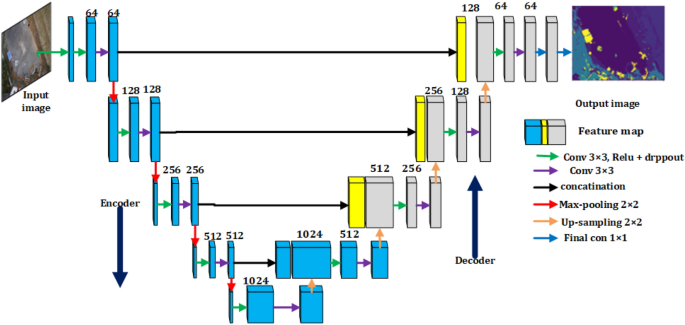

In [ ]:
def time_embedding(time_steps, time_embedding_dim):
  assert time_embedding_dim % 2 == 0, "time embedding dimension must be divisible by 2"
  factor =  10000 ** ((torch.arange(start=0, end= time_embedding_dim//2, dtype= torch.float32, device=time_steps.device)))
  time_embedding = time_steps[:, None].repeat(1, time_embedding_dim//2) / factor
  time_embedding = torch.cat([torch.sin(time_embedding), torch.cos(time_embedding)], dim=-1)
  return time_embedding

In [ ]:
class encoder(nn.Module):
  def __init__(self, ip_ch, op_ch, time_embedding_dim, down_sample=True, num_heads=4, num_layers=1):
    super().__init__()
    self.number_layers = num_layers
    self.down_sample = down_sample

    self.resnet_first = nn.ModuleList(
        [
        nn.Sequential(
            nn.GroupNorm(8, ip_ch if i == 0 else op_ch),
            nn.SiLU(),
            nn.Conv2d(ip_ch if i == 0 else op_ch, op_ch, kernel_size=3, stride=1, padding=1)
          )
          for i in range(self.number_layers)
        ]
    )

    self.time_embedding_layer = nn.ModuleList([
        nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_embedding_dim, op_ch)
            )
            for _ in range(self.number_layers)
        ]
    )

    self.resnet_second = nn.ModuleList(
        [
            nn.Sequential(
                nn.GroupNorm(8, op_ch),
                nn.SiLU(),
                nn.Conv2d(op_ch, op_ch, kernel_size=3, stride=1, padding=1),
            )
            for _ in range(self.number_layers)
        ]
    )
    self.attention_normalization = nn.ModuleList(
        [
            nn.GroupNorm(8,op_ch) for _ in range(self.number_layers)
        ]
    )

    self.attention = nn.ModuleList([
        nn.MultiheadAttention(op_ch, num_heads, batch_first=True)
        for _ in range(self.number_layers)]
    )

    self.residual_ip = nn.ModuleList(
        [
            nn.Conv2d(ip_ch if i == 0 else op_ch, op_ch, kernel_size=1)
            for i in range(self.number_layers)
        ]
    )

    self.down_sample = nn.Conv2d(op_ch,op_ch,4,2,1) if self.down_sample else nn.Identity()

  def forward(self, x, time_embedding):
    op = x
    for i in range(self.number_layers):
      resnet_ip = op
      op = self.resnet_first[i](op)
      op = op + self.time_embedding_layer[i](time_embedding)[:, :, None, None]
      op = self.resnet_second[i](op)
      op = op + self.residual_ip[i](resnet_ip)
      batch_size, channels, h, w = op.shape
      ip_att = op.reshape(batch_size, channels, h*w)
      ip_att = self.attention_normalization[i](ip_att)
      ip_att = ip_att.transpose(1,2)
      op_att, _ = self.attention[i](ip_att, ip_att, ip_att)
      op_att = op_att.transpose(1,2).reshape(batch_size, channels, h, w)
      op = op + op_att
    op = self.down_sample(op)
    return op


In [ ]:
class UNetMid(nn.Module):
  def __init__(self,ip_ch,op_ch,time_embedding_dim,num_heads=4,num_layers=1):
    super().__init__()
    self.number_layers = num_layers

    self.resnet_first = nn.ModuleList(
        [
            nn.Sequential(
                nn.GroupNorm(8, ip_ch if i == 0 else op_ch),
                nn.SiLU(),
                nn.Conv2d(ip_ch if i==0 else op_ch, op_ch, kernel_size=3, stride=1, padding=1),
            )
            for i in range(self.number_layers + 1)
        ]
    )

    self.time_embedding_layer = nn.ModuleList(
        [
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_embedding_dim, op_ch)
            )
            for _ in range(self.number_layers + 1)
        ]
    )

    self.resnet_second = nn.ModuleList(
        [
            nn.Sequential(
                nn.GroupNorm(8,op_ch),
                nn.SiLU(),
                nn.Conv2d(op_ch, op_ch, kernel_size=3, stride=1, padding=1),
            )
            for _ in range(self.number_layers + 1)
        ]
    )

    self.attention_normalization = nn.ModuleList(
        [
            nn.GroupNorm(8, op_ch) for _ in range(self.number_layers)
        ]
    )

    self.attention = nn.ModuleList(
        [
            nn.MultiheadAttention(op_ch,num_heads, batch_first=True) for _ in range(self.number_layers)
        ]
    )

    self.residual_ip = nn.ModuleList(
        [
            nn.Conv2d(ip_ch if i == 0 else op_ch, op_ch, kernel_size=1) for i in range(self.number_layers + 1)
        ]
    )


  def forward(self,x,time_embedding):
    op = x
    resnet_ip = op
    op = self.resnet_first[0](op)
    op = op + self.time_embedding_layer[0](time_embedding)[:, :, None, None]
    op = self.resnet_second[0](op)
    op = op +  self.residual_ip[0](resnet_ip)
    for i in range(self.number_layers):
      batch_size, channels, h, w = op.shape
      ip_att = op.reshape(batch_size, channels, h*w)
      ip_att = self.attention_normalization[i](ip_att)
      ip_att = ip_att.transpose(1,2)
      op_att, _ = self.attention[i](ip_att, ip_att, ip_att)
      op_att = op_att.transpose(1,2).reshape(batch_size, channels, h, w)
      op = op + op_att
      resnet_ip = op
      op = self.resnet_first[i+1](op)
      op = op + self.time_embedding_layer[i+1](time_embedding)[:, :, None, None]
      op = self.resnet_second[i+1](op)
      op = op + self.residual_ip[i+1](resnet_ip)
    return op

In [ ]:
class decoder(nn.Module):
  def __init__(self, ip_ch, op_ch, time_embedding_dim, up_sample=True, num_heads=4, num_layers=1):
    super().__init__()
    self.number_layers = num_layers
    self.up_sample = up_sample

    self.resnet_first = nn.ModuleList(
        [
            nn.Sequential(
                nn.GroupNorm(8, ip_ch if i ==0 else op_ch),
                nn.SiLU(),
                nn.Conv2d(ip_ch if i == 0 else op_ch, op_ch, kernel_size=3, stride=1, padding=1)
            )
            for i in range(self.number_layers)
        ]
    )

    self.time_embedding_layer = nn.ModuleList(
        [
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_embedding_dim, op_ch)
            )
            for _ in range(self.number_layers)
        ]

    )

    self.resnet_second = nn.ModuleList(
        [
            nn.Sequential(
                nn.GroupNorm(8, op_ch),
                nn.SiLU(),
                nn.Conv2d(op_ch, op_ch, kernel_size=3, stride=1, padding=1)
            )
            for _ in range(self.number_layers)
        ]
    )

    self.attention_normalization = nn.ModuleList(
        [
            nn.GroupNorm(8, op_ch) for _ in range(self.number_layers)
        ]
    )

    self.attention = nn.ModuleList(
        [
            nn.MultiheadAttention(op_ch, num_heads, batch_first=True) for _ in range(self.number_layers)
        ]
    )

    self.residual_ip = nn.ModuleList(
        [
            nn.Conv2d(ip_ch if i == 0 else op_ch, op_ch, kernel_size=1) for i in range(self.number_layers)
        ]
    )

    self.up_sample = nn.ConvTranspose2d(ip_ch //2, ip_ch // 2, 4, 2, 1) if self.up_sample else nn.Identity()

  def forward(self, x, op_down, time_embedding):
    x = self.up_sample(x)
    x = torch.cat([x, op_down], dim=1)
    op = x
    for i in range(self.number_layers):
      resnet_ip = op
      op = self.resnet_first[i](op)
      op = op + self.time_embedding_layer[i](time_embedding)[:, :, None, None]
      op = self.resnet_second[i](op)
      op = op + self.residual_ip[i](resnet_ip)
      batch_size, channels, h, w = op.shape
      ip_att = op.reshape(batch_size, channels, h*w)
      ip_att = self.attention_normalization[i](ip_att)
      ip_att = ip_att.transpose(1,2)
      op_att, _ = self.attention[i](ip_att, ip_att, ip_att)
      op_att = op_att.transpose(1,2).reshape(batch_size, channels, h, w)
      op = op + op_att
    return op


In [ ]:
class UNet(nn.Module):
  def __init__(self,model_config):
    super().__init__()
    model_params = config['model_params']
    img_ch = model_params['im_channels']
    self.encode_ch = model_params['encode_channels']
    self.mid_ch = model_params['mid_channels']
    self.time_embedding_dim = model_params['time_emb_dim']
    self.down_sample = model_params['down_sample']
    self.num_encode_layers = model_params['num_encode_layers']
    self.num_mid_layers = model_params['num_mid_layers']
    self.num_decode_layers = model_params['num_decode_layers']

    assert self.mid_ch[0] == self.encode_ch[-1]
    assert self.mid_ch[-1] == self.encode_ch[-2]
    assert len(self.down_sample) == len(self.encode_ch)

    self.time_projection = nn.Sequential(
        nn.Linear(self.time_embedding_dim, self.time_embedding_dim),
        nn.SiLU(),
        nn.Linear(self.time_embedding_dim, self.time_embedding_dim)
    )

    self.decode_sample = list(reversed(self.down_sample))
    self.encode_ip = nn.Conv2d(img_ch, self.encode_ch[0], kernel_size=3, padding=(1,1))

    self.encode = nn.ModuleList([])
    for i in range(len(self.encode_ch) - 1):
      self.encode.append(encoder(self.encode_ch[i], self.encode_ch[i+1], self.time_embedding_dim, down_sample=self.down_sample[i], num_layers=self.num_encode_layers))

    self.mid = nn.ModuleList([])
    for i in range(len(self.mid_ch) - 1):
      self.mid.append(UNetMid(self.mid_ch[i], self.mid_ch[i+1], self.time_embedding_dim, num_layers=self.num_mid_layers))

    self.decode = nn.ModuleList([])
    for i in reversed(range(len(self.encode_ch) - 1)):
      self.decode.append(decoder(self.encode_ch[i] * 2, self.encode_ch[i-1] if i!= 0 else 16, self.time_embedding_dim, up_sample=self.down_sample[i], num_layers=self.num_decode_layers))

    self.norm_op = nn.GroupNorm(8,16)
    self.decode_op = nn.Conv2d(16, img_ch, kernel_size=3, padding=1)

  def forward(self,x,t):
    op = self.encode_ip(x)
    time_embeddings = time_embedding(torch.as_tensor(t).long(), self.time_embedding_dim)
    time_embeddings = self.time_projection(time_embeddings)
    encode_op = []

    for idx, encodes in enumerate(self.encode):
      encode_op.append(op)
      op = encodes(op, time_embeddings)

    for mids in self.mid:
      op = mids(op, time_embeddings)

    for decodes in self.decode:
      op = decodes(op, encode_op.pop(), time_embeddings)

    op = self.norm_op(op)
    op = nn.SiLU()(op)
    op = self.decode_op(op)
    return op


##**Dataset Load**

In [ ]:
# kaggle_json_path = '/content/drive/MyDrive/DDPM/kaggle.json'
# if os.path.exists(kaggle_json_path):
#     !mkdir -p ~/.kaggle
#     !cp '{kaggle_json_path}' ~/.kaggle/
#     !chmod 600 ~/.kaggle/kaggle.json
#     print("Kaggle API başarıyla ayarlandı!")
# else:
#     print(f"HATA: {kaggle_json_path} dosyası bulunamadı!")
#     print("Lütfen kaggle.json dosyasını belirtilen yola yüklediğinizden emin olun.")

In [ ]:
# !kaggle datasets download -d dimensi0n/afhq-512

# !mv afhq-512.zip '/content/drive/MyDrive/DDPM/afhq'

In [ ]:
# zip_path = '/content/drive/MyDrive/DDPM/afhq/afhq-512.zip'
# extract_path = '/content/drive/MyDrive/DDPM/afhq'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Veri seti başarıyla çıkarıldı!")

In [ ]:
# def resize_image(file_path, output_path, target_size=(64, 64)):
#     """Resize a single image and save it to the output path."""
#     try:
#         with Image.open(file_path) as img:
#             img = img.convert('RGB')
#             img_resized = img.resize(target_size, Image.LANCZOS)
#             img_resized.save(output_path, quality=95)
#             return True
#     except Exception as e:
#         print(f"Error processing {file_path}: {e}")
#         return False

# def resize_images_in_directory(source_dir, target_size=(64, 64)):
#     """Resize all images in source directory and its subdirectories."""
#     subdirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

#     image_files = []
#     for subdir in subdirs:
#         subdir_path = os.path.join(source_dir, subdir)

#         for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
#             pattern = os.path.join(subdir_path, ext)
#             image_files.extend(glob.glob(pattern))

#     print(f"Found {len(image_files)} images to resize")

#     num_workers = min(multiprocessing.cpu_count(), 8)
#     with ThreadPoolExecutor(max_workers=num_workers) as executor:
#         futures = []
#         for img_path in image_files:
#             relative_path = os.path.relpath(img_path, source_dir)
#             output_path = img_path
#             futures.append(executor.submit(resize_image, img_path, output_path, target_size))

#         success_count = 0
#         for future in tqdm(futures, desc="Resizing images"):
#             if future.result():
#                 success_count += 1

#     print(f"Successfully resized {success_count} out of {len(image_files)} images")

# source_directory = "/content/drive/MyDrive/DDPM/afhq"
# resize_images_in_directory(source_directory, target_size=(64, 64))

In [ ]:
# def reduce_images_in_directory(source_dir):
#     subdirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

#     total_removed = 0

#     for subdir in subdirs:
#         subdir_path = os.path.join(source_dir, subdir)

#         image_files = []
#         for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
#             pattern = os.path.join(subdir_path, ext)
#             image_files.extend(glob.glob(pattern))

#         num_to_keep = len(image_files) // 2

#         files_to_remove = random.sample(image_files, len(image_files) - num_to_keep)

#         print(f"Folder {subdir}: Found {len(image_files)} images, keeping {num_to_keep}, removing {len(files_to_remove)}")

#         for file_path in tqdm(files_to_remove, desc=f"Removing images from {subdir}"):
#             try:
#                 os.remove(file_path)
#                 total_removed += 1
#             except Exception as e:
#                 print(f"Error removing {file_path}: {e}")

#     print(f"Successfully removed {total_removed} images. Dataset size reduced by approximately 50%.")

# source_directory = "/content/drive/MyDrive/DDPM/afhq"
# reduce_images_in_directory(source_directory)

In [ ]:
class AFHQDataset(Dataset):
    def __init__(self, split, im_path, im_ext='png'):
        self.split = split
        self.im_ext = im_ext
        self.images, self.labels = self.load_images(im_path)

        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def load_images(self, im_path):
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        ims = []
        labels = []

        class_names = sorted(os.listdir(im_path))  # ['cat', 'dog', 'wild']
        class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for d_name in tqdm(os.listdir(im_path)):
            if os.path.isdir(os.path.join(im_path, d_name)):
                for fname in glob.glob(os.path.join(im_path, d_name, '*.{}'.format(self.im_ext))):
                    ims.append(fname)
                    labels.append(class_to_idx[d_name])

        print('Found {} images for split {}'.format(len(ims), self.split))
        return ims, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

## **Trainig**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train():
  diffusion_config = config['diffusion_params']
  dataset_config = config['dataset_params']
  model_config = config['model_params']
  train_config = config['train_params']

  scheduler = NoiseScheduler(timesteps=diffusion_config['num_timesteps'],
                             beta_start=diffusion_config['beta_start'],
                             beta_end=diffusion_config['beta_end'])
  dataset = AFHQDataset('train', dataset_config['im_path'])
  dataloader = DataLoader(dataset, batch_size=train_config['batch_size'], shuffle=True, num_workers=8)

  model = UNet(model_config).to(device)
  model.train()

  if not os.path.exists(train_config['task_name']):
    os.makedirs(train_config['task_name'])

  if os.path.exists(os.path.join(train_config['task_name'], train_config['ckpt_name'])):
    print("Loding checkpoint...")
    model.load_state_dict(torch.load(os.path.join(train_config['task_name'], train_config['ckpt_name']), map_location=device))

  num_epochs = train_config['num_epochs']
  optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])
  criterion = torch.nn.MSELoss()

  for epoch_idx in range(num_epochs):
    losses = []
    for img, _ in tqdm(dataloader):
      optimizer.zero_grad()
      img = img.float().to(device)
      noise = torch.randn_like(img).to(device)
      t = torch.randint(0, diffusion_config['num_timesteps'],(img.shape[0],)).to(device)
      noisy_img = scheduler.add_noise(img, noise, t)
      noise_pred = model(noisy_img, t)
      loss = criterion(noise_pred, noise)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
    print("Epoch: {} | Loss: {}".format(epoch_idx + 1, np.mean(losses)))
    torch.save(model.state_dict(), os.path.join(train_config["task_name"], train_config["ckpt_name"]))
if __name__ == "__main__":
  train()

NameError: name 'AFHQDataset' is not defined

## **Image Generation**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def sample(model, scheduler, train_config, model_config, diffusion_config):
  xt = torch.randn((train_config['num_samples'], model_config['im_channels'],model_config['im_size'],model_config['im_size'])).to(device)
  for i in tqdm(reversed(range(diffusion_config['num_timesteps']))):
    noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))
    xt, x0_pred = scheduler.remove_noise(xt, noise_pred, torch.as_tensor(i).to(device))
    imgs = torch.clamp(xt,-1., 1.).detach().cpu()
    imgs = (imgs + 1) / 2
    grid = make_grid(imgs, nrow=train_config['num_grid_rows'])
    img = torchvision.transforms.ToPILImage()(grid)
    if not os.path.exists(os.path.join(train_config['task_name'], 'samples')):
      os.makedirs(os.path.join(train_config['task_name'], 'samples'))
    img.save(os.path.join(train_config['task_name'], 'samples', 'x0_{}.png'.format(i)))
    img.close()

def inference():
    diffusion_config = config['diffusion_params']
    model_config = config['model_params']
    train_config = config['train_params']
    model = UNet(model_config).to(device)
    model.load_state_dict(torch.load(os.path.join(train_config['task_name'],train_config['ckpt_name']),map_location=device))
    model.eval()
    scheduler = NoiseScheduler(timesteps=diffusion_config['num_timesteps'],
                               beta_start=diffusion_config['beta_start'],
                               beta_end=diffusion_config['beta_end'])
    with torch.no_grad():
      sample(model, scheduler, train_config, model_config, diffusion_config)
if __name__ == "__main__":
  inference()

800it [02:46,  4.82it/s]
